## Introduction
Leverage is a powerful tool that can significantly amplify the performance of a portfolio, but it also comes with the trade-off of increased risk. In this brief study, we focus on a daily-rebalanced leveraged ETF (LETF). Due to daily re-leveraging, LETFs tend to be negatively impacted by periods of high volatility, a phenomenon known as volatility decay (see, e.g., Ref. 1). Conversely, LETFs can benefit from extended periods of low volatility and positive returns. The purpose of this study is to explore a potential strategy for identifying periods of low volatility, during which LETFs may outperform their underlying index.

### Disclaimer
The content provided here is for educational purposes only. It is not intended as financial advice or as a recommendation for any particular investment strategy.

## Methods
The strategy analyzed in this study involves rotating between a LETF and short-term bonds based on whether the LETF's underlying index is above or below its moving average. We consider various moving average periods to evaluate their impact. The index under consideration is the NASDAQ 100, and we analyze two LETFs: a 2x leveraged ETF (*Amundi Nasdaq-100 2x Daily Leveraged*, ticker: LQQ.PA) and a 3x leveraged ETF (*WisdomTree NASDAQ 100 3x Daily Leveraged*, ticker: QQQ3.MI).

## Analysis of the volatility
We analyze the volatility of the NASDAQ 100 index from January 1, 1990, to October 1, 2024. Using a moving average window of length T, we evaluate the volatility of the index during periods when it is either above or below its moving average.

<img src="leveraged_portfolio_analysis_volatility_comparison.png" height="400" />

The results of a Mann-Whitney U Test are provided in the code below. As shown in the figure, the index exhibits **significantly lower volatility when it is above its rolling average compared to when it is below**.

## Analysis of the strategy
The main parameter of the strategy is the length of the moving average window. A short window (e.g., 50 days) is more responsive to recent market changes, allowing for quicker adjustments but at the cost of more frequent trading and potential whipsawing. In contrast, a long window (e.g., 300 days) results in fewer trades and is less reactive to short-term market fluctuations, potentially providing more stability but being slower to adapt to new trends.

## References


In [3]:
# Importing necessary libraries for data handling, financial data retrieval, visualization, and statistical analysis
import matplotlib.pyplot as plt   # For data visualization
import yfinance as yf             # To fetch financial data
import numpy as np                # For numerical computations
import pandas as pd               # For data manipulation and analysis
import seaborn as sns             # For advanced visualizations
import scipy                      # For statistical analysis

In [2]:
'''
Compare the volatility of the NASDAQ 100 (^NDX) during periods when it is above its moving average versus when it is below, 
across various moving average window lengths. This analysis is visualized using a violin plot.
'''

# Download NASDAQ 100 (^NDX) historical data from Yahoo Finance (1990-01-01 to 2024-10-01)
data = yf.download('^NDX',group_by='Date', start="1990-01-01", end="2024-10-01")
data['Pct Change'] = data['Adj Close'].pct_change()

# Define moving average window lengths for comparison
window_lengths = [50, 100, 200, 300]
results        = pd.DataFrame()

# Loop over each window length to calculate volatility above and below the moving average
for window_length in window_lengths:
    # Generate signal to mark periods when the index is above its moving average
    above_moving_average = data['Adj Close']>data['Adj Close'].rolling(window = window_length).mean()

    periods_above = []
    periods_below = []

    i = 0
    while i<len(above_moving_average):
        # Identify periods below the moving average
        current_period = []
        while i<len(above_moving_average) and above_moving_average.iloc[i]==False:
            current_period.append(i)
            i+=1
        else:
            if len(current_period)>0:
                periods_below.append(current_period)
        # Identify periods above the moving average
        current_period = []
        while i<len(above_moving_average) and above_moving_average.iloc[i]==True:
            current_period.append(i)
            i+=1
        else:
            if len(current_period)>0:
                periods_above.append(current_period)
    
    volatilities_above = []
    volatilities_below = []

    # Calculate volatilities for periods above moving average
    for period in periods_above:
        if len(period)<6:
            # Skip short periods
            continue
        volatility  = data['Pct Change'].iloc[period].std() * (trading_days_in_year**0.5)
        results = results._append({'window': window_length, 'above': True, 'volatility': volatility, 'length': len(period)}, ignore_index=True)
        volatilities_above.append(volatility)
     # Calculate volatilities for periods below moving average
    for period in periods_below:
        if len(period)<6:
            # Skip short periods
            continue
        volatility  = data['Pct Change'].iloc[period].std() * (trading_days_in_year**0.5)
        results = results._append({'window': window_length, 'above': False, 'volatility': volatility, 'length': len(period)}, ignore_index=True)
        volatilities_below.append(volatility)

    # Perform Mann-Whitney U Test to compare volatilities
    Utest = scipy.stats.mannwhitneyu(results[results['above']==False]['volatility'], results[results['above']==True]['volatility'], alternative='greater')
    # Print results for the current window length
    print(f"{window_length:>3}-days period:  Above m.m.   | Below m.m.")
    print(f"     Volatility:  {100*np.mean(volatilities_above):.2f}%       | {100*np.mean(volatilities_below):.2f}%")
    print(f"     pvalue:      {Utest.pvalue}")
    print(" ")

# Create a violin plot to visualize the distribution of volatilities for each window length
p = sns.violinplot(data=results, x="window", y="volatility", hue="above",split=True, inner="quart")
handles, labels = p.get_legend_handles_labels()
p.legend(handles=handles, title="", labels=['Below moving average', 'Above moving average'])
plt.xlabel("Moving average window length (days)")
plt.ylabel("Volatility")
#plt.savefig('leveraged_portfolio_analysis_volatility_comparison.png')
plt.show()

NameError: name 'yf' is not defined

[*********************100%***********************]  4 of 4 completed


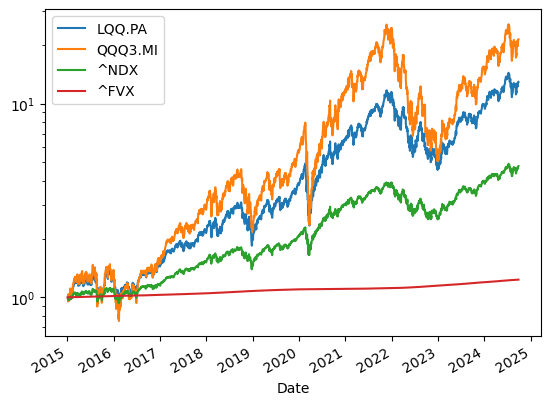

In [4]:
# Downloading and Processing Financial Data

# Tickers to download: 2x Leveraged NASDAQ100, 3x Leveraged NASDAQ100, NASDAQ100
tickers   = ["LQQ.PA", "QQQ3.MI", "^NDX"]
# US treasury yield (5 years) as the risk-free rate
risk_free = ["^FVX"]                     

# Download the data from Yahoo Finance (2015-01-01 to 2024-09-27)
data      = yf.download(tickers+risk_free,group_by='Date', start="2015-01-01", end="2024-09-27")

# Download the data from Yahoo Finance (2015-01-01 to 2024-09-27)
num_years               = (data.index[-1]-data.index[0]).days/365
trading_days_in_year    = int(len(data.index)/num_years)

# Process tickers: forward-fill missing data and compute daily percentage change for all tickers
for ticker in tickers:
    data[(ticker, 'Adj Close')] = data[(ticker, 'Adj Close')].ffill()
    data[(ticker,'Pct Change')] = data[(ticker, 'Adj Close')].pct_change()
# Process risk-free rate: convert yield to percentage change, adjust for trading days, and calculate cumulative product
for ticker in risk_free:
    data[(ticker, 'Adj Close')]  = data[(ticker, 'Adj Close')].ffill()
    data[(ticker, 'Pct Change')] = data[(ticker,'Adj Close')].div(100*trading_days_in_year)
    data[(ticker, 'Adj Close')]  = data[(ticker, 'Pct Change')].add(1).cumprod()
# Re-sort the columns by ticker after adding new columns
data.sort_index(axis=1, inplace=True) 

# Plot the cumulative product of percentage changes for all tickers and risk-free rate
for ticker in tickers+risk_free:
    data[(ticker,'Pct Change')].add(1).cumprod().plot(label=ticker)

plt.yscale('log') # Set y-axis scale to logarithmic
plt.legend()
plt.show()

In [5]:
# Calculate Performance Metrics

# Print the period of analysis
print(f"Period: {num_years:.1f} years")

# Calculate the annualized risk-free return (5-year US Treasury yield)
riskfree_return =  ((data[('^FVX', 'Adj Close')].iloc[-1]/data[('^FVX', 'Adj Close')].iloc[0])**(1/num_years)-1)
print(f"Annualized risk-free return: {100*riskfree_return:.1f} %")

# Loop through each ticker and calculate performance metrics
for ticker in tickers:
    print(f"Ticker: {ticker}")

    # Calculate the excess returns, annualized standard deviation, and Sharpe ratio
    excess_returns      = (data[(ticker, 'Adj Close')].iloc[-1]/data[(ticker, 'Adj Close')].iloc[0])**(1/num_years)-1 -riskfree_return
    standard_deviation  = data[(ticker, 'Pct Change')].std() * (trading_days_in_year**0.5)
    sharpe_ratio        = excess_returns / standard_deviation

    # Calculate the maximum drawdown
    current_max = maximum_drawdown= 0
    for i in range(len(data.index)):
        current_max = max(current_max, data[(ticker, 'Adj Close')].iloc[i])
        maximum_drawdown = min(maximum_drawdown, (data[(ticker, 'Adj Close')].iloc[i]-current_max)/current_max)
    
    # Print calculated metrics for the current ticker
    print(f"    Excess return      = {100*excess_returns:.1f} %")
    print(f"    Maximum drowdown   = {-100*maximum_drawdown:.1f} %")
    print(f"    Standard deviation = {100*standard_deviation:.1f} %")
    print(f"    Sharpe ratio       = {sharpe_ratio:.2f}")
    print("-------")

Period: 9.7 years
Annualized risk-free return: 2.2 %
Ticker: LQQ.PA
    Excess return      = 27.9 %
    Maximum drowdown   = 61.2 %
    Standard deviation = 39.7 %
    Sharpe ratio       = 0.70
-------
Ticker: QQQ3.MI
    Excess return      = 34.8 %
    Maximum drowdown   = 80.3 %
    Standard deviation = 59.6 %
    Sharpe ratio       = 0.58
-------
Ticker: ^NDX
    Excess return      = 15.2 %
    Maximum drowdown   = 35.6 %
    Standard deviation = 22.1 %
    Sharpe ratio       = 0.69
-------


In [15]:
# Strategy Backtest with Different Moving Average Windows

# Perform strategy backtest for different lengths of the moving average window
windows = [50, 150, 200, 250, 300]
results = []

for window_length in windows:
    # Generate a signal based on whether NASDAQ 100 is above its moving average
    above_moving_average = data[('^NDX', 'Adj Close')]>data[('^NDX', 'Adj Close')].rolling(window = window_length).mean()
    
    # Apply strategy: invest in leveraged ETF when signal is True, otherwise invest in risk-free asset
    data[('MyStrategy', 'Pct Change')] = np.where(above_moving_average.shift(1), data[('LQQ.PA', 'Pct Change')], data[('^FVX', 'Pct Change')])
    data[('MyStrategy', 'Adj Close')] = data[('MyStrategy', 'Pct Change')].add(1).cumprod()

    # Calculate the number of years of the backtest
    num_years = (data.index[-1]-data.index[window_length]).days/365

    # Calculate excess returns, annualized volatility (standard deviation), and Sharpe ratio
    excess_returns      = (data[('MyStrategy', 'Adj Close')].iloc[-1]/data[('MyStrategy', 'Adj Close')].iloc[window_length])**(1/num_years)-1 -riskfree_return
    standard_deviation  = data[('MyStrategy', 'Pct Change')].std() * (trading_days_in_year**0.5)
    sharpe_ratio        = excess_returns / standard_deviation
    
    # Print performance metrics for the current window length
    print(f"Window size: {window_length} days")
    print(f"    Excess return      = {100*excess_returns:.1f} %")
    print(f"    Standard deviation = {100*standard_deviation:.1f} %")
    print(f"    Sharpe ratio       = {sharpe_ratio:.2f}")
    print("-------")

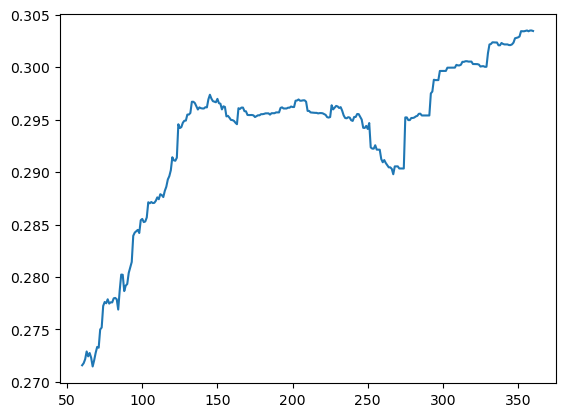

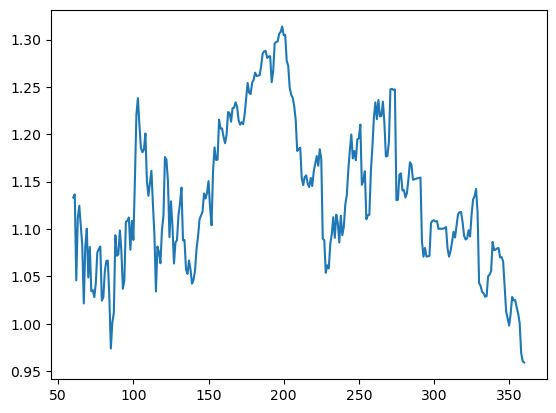

In [23]:
# Generate a plot of Sharpe, excess return, volatility as function of window_length

# Perform strategy backtest for different lengths of the moving average window
moving_average_windows = range(60, 361)
sharpe_ratios  = []
volatilities   = []

for window_length in moving_average_windows:
    # Generate a signal based on whether NASDAQ 100 is above its moving average
    above_moving_average = data[('^NDX', 'Adj Close')]>data[('^NDX', 'Adj Close')].rolling(window = window_length).mean()
    
    # Apply strategy: invest in leveraged ETF when signal is True, otherwise invest in risk-free asset
    data[('MyStrategy', 'Pct Change')] = np.where(above_moving_average.shift(1), data[('LQQ.PA', 'Pct Change')], data[('^FVX', 'Pct Change')])
    data[('MyStrategy', 'Adj Close')] = data[('MyStrategy', 'Pct Change')].add(1).cumprod()

    # Calculate the number of years of the backtest
    num_years = (data.index[-1]-data.index[window_length]).days/365

    # Calculate excess returns, annualized volatility (standard deviation), and Sharpe ratio
    excess_returns      = (data[('MyStrategy', 'Adj Close')].iloc[-1]/data[('MyStrategy', 'Adj Close')].iloc[window_length])**(1/num_years)-1 -riskfree_return
    standard_deviation  = data[('MyStrategy', 'Pct Change')].std() * (trading_days_in_year**0.5)
    sharpe_ratio        = excess_returns / standard_deviation
    
    # Print performance metrics for the current window length
    sharpe_ratios.append(sharpe_ratio)
    volatilities.append(standard_deviation)


plt.plot(moving_average_windows, volatilities)
plt.show()
plt.plot(moving_average_windows, sharpe_ratios)
plt.show()



In [61]:

data.head

<bound method NDFrame.head of                     Open          High           Low         Close  \
Date                                                                 
1985-10-01    110.620003    112.160004    110.565002    112.139999   
1985-10-02    112.139999    112.540001    110.779999    110.824997   
1985-10-03    110.839996    111.184998    110.120003    110.870003   
1985-10-04    110.870003    110.870003    109.855003    110.074997   
1985-10-07    110.074997    110.135002    108.175003    108.199997   
...                  ...           ...           ...           ...   
2024-09-24  19917.560547  19984.470703  19739.669922  19944.839844   
2024-09-25  19922.279297  20043.429688  19921.220703  19972.609375   
2024-09-26  20273.300781  20273.300781  19966.990234  20115.539062   
2024-09-27  20147.279297  20152.529297  19964.130859  20008.619141   
2024-09-30  19959.259766  20072.429688  19852.849609  20060.689453   

               Adj Close      Volume  
Date                

In [12]:
r = scipy.stats.mannwhitneyu(results[results['above']==False]['volatility'], results[results['above']==True]['volatility'], alternative='greater')


In [15]:
print(f"{r.pvalue}")

1.3274920818640852e-20:.2f


In [2]:
trading_days_in_year

258